# 평균모멘텀스코어 현금 혼합 그림 2-28
- 투자 기간 :1986년 1월~2017년 6월
- 투자 대상 : 코스피200지수(코스피200지수 추종 ETF), 현금(3년 만기 국고채=> 이론현금)
- 매수 규칙 :
  -  주식 : 현금 투자비율 = 주식 1~12개월 평균 모멘텀 스코어:1(현금 평균 모멘텀 비중)
- 매도 규칙 : 매달 말 위의 투자 비중을 새로 계산하여 주식 :현금 투자 비중을 조절하여 반복
- 문제점 : 횡보장(2011.6~2016)
## 현금 비중 조절
- 현금비중 2   : 현금 최소 66%이상 보유 저위험, 저수익(5.90%/-8.7%)
- 현금비중 0.5 : 현금 최소 33%이상 보유 고위험, 고수익(8.51%/-31.6%)

In [1]:
from settings import *

In [2]:
# %load_ext autoreload
# %autoreload 2

In [3]:
# 직접생성
# kospi = fdr.DataReader("KS11")['Close']
# df = pd.DataFrame()
# df['KOSPI'] = kospi.copy()
# df = df['1985-1':'2017-6'].resample('MS').first() # 실제 말 마지막날이 공휴일이어도 마지막날 거래 한것과 같이 된다.
# df['현금'] = pow(1.03, 1/12)
# df['현금'] = df['현금'].shift(1, fill_value=1.0)
# df['현금'] = df['현금'].cumprod()
# df

In [4]:
df = pd.read_csv('kospi_m.csv', index_col=0, parse_dates=True)
#-------------------------------------------
df['현금'] = pow(1.03, 1/12)
df['현금'] = df['현금'].shift(1, fill_value=1.0)
df['현금'] = df['현금'].cumprod()
#-------------------------------------------
df.head()

,KOSPI,현금
날짜,,
1985-01-04,1.000,1.000
1985-02-01,0.970,1.002
1985-03-02,0.982,1.005
1985-04-01,0.966,1.007
1985-05-01,0.965,1.010


In [5]:
df.tail()

,KOSPI,현금
날짜,,
2017-03-02,15.552,2.588
2017-04-03,15.878,2.594
2017-05-02,16.900,2.601
2017-06-01,17.220,2.607
2017-07-03,17.250,2.613


In [6]:
start모멘텀 = '1986-1-4'
s = '1985-1-4'
e = '2017-6-1'

In [7]:
data = df[s:e].copy()
data

,KOSPI,현금
날짜,,
1985-01-04,1.000,1.000
1985-02-01,0.970,1.002
1985-03-02,0.982,1.005
1985-04-01,0.966,1.007
1985-05-01,0.965,1.010
...,...,...
2017-02-01,15.059,2.581
2017-03-02,15.552,2.588
2017-04-03,15.878,2.594


In [8]:
bt_ew = long_only_ew(data, ['KOSPI', '현금'], "ew")

In [9]:
def 평균모멘텀(데이터):
    초기값 = 0
    for i in range(1, 13):
        초기값 = 데이터 / 데이터.shift(i) + 초기값
    return 초기값 / 12

def 모멘텀순위(데이터, 순위):
    x = 평균모멘텀(데이터)
    y = x.iloc[ : , 0: len(x.columns)].rank(1, ascending=0)
    y[y <= 순위] = 1
    y[y > 순위] = 0
    return y

def 평균모멘텀스코어(데이터):
    a = 평균모멘텀(데이터).copy()
    초기값 = 0
    for i in range(1, 13):
        초기값 = np.where(데이터 / 데이터.shift(i) > 1, 1, 0) + 초기값
    a[a > -1] = 초기값/12
    return a

In [10]:
score = 평균모멘텀스코어(data)

In [11]:
# KOSPI만 평균모멘텀스코어 비중 만큼 투자하고 나머지는 현금
weights0 = pd.DataFrame()
weights0['KOSPI'] = score['KOSPI']
weights0['현금']  = 1.0 - score['KOSPI']
weights0.dropna().head(10) # 1986-1 이후 유효

,KOSPI,현금
날짜,,
1986-01-04,0.917,0.083
1986-02-01,1.000,0.000
1986-03-03,1.000,0.000
1986-04-01,1.000,0.000
1986-05-01,1.000,0.000
1986-06-02,1.000,0.000
1986-07-01,1.000,0.000
1986-08-01,0.917,0.083
1986-09-01,0.833,0.167


In [12]:
# 현금도 하나의 자산으로 취급. 이론 현금은 항상 모멘텀스코어가 1이다.
# 따라서 주식 비중이 0.5를 넘을 수 없다.
weights1 = score.copy()
weights1 = weights1.div(weights1.sum(axis=1), axis=0)
weights1.dropna().head(10)

,KOSPI,현금
날짜,,
1986-01-04,0.478,0.522
1986-02-01,0.500,0.500
1986-03-03,0.500,0.500
1986-04-01,0.500,0.500
1986-05-01,0.500,0.500
1986-06-02,0.500,0.500
1986-07-01,0.500,0.500
1986-08-01,0.478,0.522
1986-09-01,0.455,0.545


In [13]:
# 위와 결과가 동일
현금비중 = 1
weights1 = score.copy()
weights1['현금'] = weights1['현금'].multiply(현금비중) #!!
weights1 = weights1.div(weights1.sum(axis=1), axis=0)
weights1.dropna().head(10)

,KOSPI,현금
날짜,,
1986-01-04,0.478,0.522
1986-02-01,0.500,0.500
1986-03-03,0.500,0.500
1986-04-01,0.500,0.500
1986-05-01,0.500,0.500
1986-06-02,0.500,0.500
1986-07-01,0.500,0.500
1986-08-01,0.478,0.522
1986-09-01,0.455,0.545


In [14]:
# 현금 비중
현금비중 = 2
weights2 = score.copy()
weights2['현금'] = weights2['현금'].multiply(현금비중) #!!
weights2 = weights2.div(weights2.sum(axis=1), axis=0)
weights2.dropna().head(10)

,KOSPI,현금
날짜,,
1986-01-04,0.314,0.686
1986-02-01,0.333,0.667
1986-03-03,0.333,0.667
1986-04-01,0.333,0.667
1986-05-01,0.333,0.667
1986-06-02,0.333,0.667
1986-07-01,0.333,0.667
1986-08-01,0.314,0.686
1986-09-01,0.294,0.706


In [15]:
현금비중=0.5
weights_0_5 = score.copy()
weights_0_5['현금'] = weights_0_5['현금'].multiply(현금비중)
weights_0_5 = weights_0_5.div(weights_0_5.sum(axis=1), axis=0)
weights_0_5.dropna().head(10)

,KOSPI,현금
날짜,,
1986-01-04,0.647,0.353
1986-02-01,0.667,0.333
1986-03-03,0.667,0.333
1986-04-01,0.667,0.333
1986-05-01,0.667,0.333
1986-06-02,0.667,0.333
1986-07-01,0.667,0.333
1986-08-01,0.647,0.353
1986-09-01,0.625,0.375


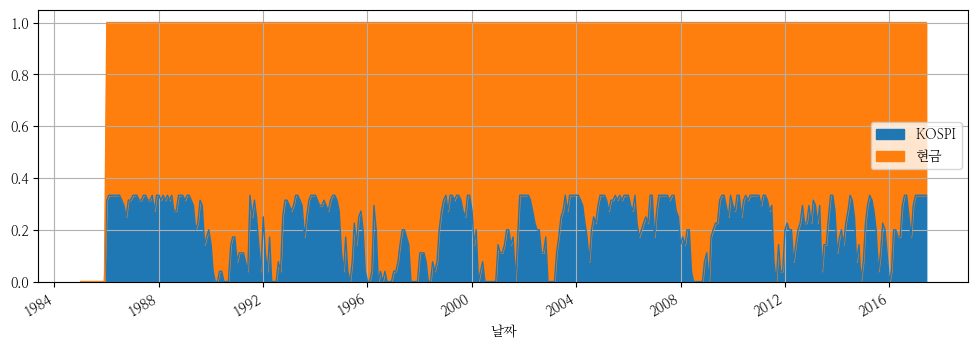

In [18]:
weights2.plot.area(figsize=(12,4));

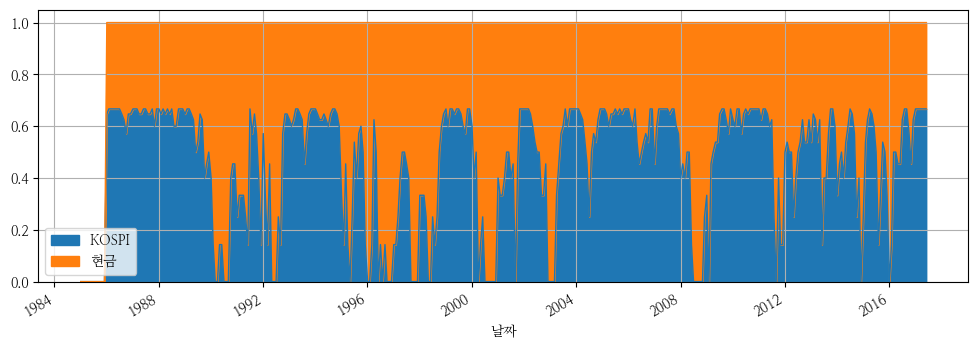

In [19]:
weights_0_5.plot.area(figsize=(12,4));

In [20]:
def momentumscore(data, weights, name="MomScore", start='1986-1-03'):
    st = bt.Strategy(
        name,
        [
            bt.algos.RunMonthly(run_on_last_date=True),
            bt.algos.RunAfterDate(start), #1년 뒤부터 시작 : 시작전 12개월 데이터 필요
            bt.algos.SelectAll(),
            bt.algos.WeighTarget(weights),
            PrintTempWeights(),
            bt.algos.Rebalance()
        ]
    )
    return bt.Backtest(st, data, initial_capital=100000000.0)

In [21]:
# shift(1)을 하면 전달 기준으로 모멘텀 계산
bt_ms0 = momentumscore(data, weights0.dropna(), name='모멘텀 포트폴리오(KOSPI)')#.shift(1))
bt_ms1 = momentumscore(data, weights1.dropna(), name='모멘텀 포트폴리오(현금혼합1)')#.shift(1))
bt_ms2 = momentumscore(data, weights2.dropna(), name='모멘텀 포트폴리오(현금혼합2)')#.shift(1))
bt_ms_0_5 = momentumscore(data, weights_0_5.dropna(), name='모멘텀 포트폴리오(현금혼합0.5)')#.shift(1))

In [22]:
bt_kospi = long_only_ew(data, ['KOSPI'], 'KOSPI')
bt_현금 = long_only_ew(data, ['현금'], '현금')

In [23]:
r_ms0 = bt.run(bt_ms0)
r_ms1 = bt.run(bt_ms1)
r_ms2 = bt.run(bt_ms2)
r_ms_0_5 = bt.run(bt_ms_0_5)

1986-01-04 00:00:00 모멘텀 포트폴리오(KOSPI) KOSPI:0.917 현금:0.083 
1986-02-01 00:00:00 모멘텀 포트폴리오(KOSPI) KOSPI:1.000 현금:0.000 
1986-03-03 00:00:00 모멘텀 포트폴리오(KOSPI) KOSPI:1.000 현금:0.000 
1986-04-01 00:00:00 모멘텀 포트폴리오(KOSPI) KOSPI:1.000 현금:0.000 
1986-05-01 00:00:00 모멘텀 포트폴리오(KOSPI) KOSPI:1.000 현금:0.000 
1986-06-02 00:00:00 모멘텀 포트폴리오(KOSPI) KOSPI:1.000 현금:0.000 
1986-07-01 00:00:00 모멘텀 포트폴리오(KOSPI) KOSPI:1.000 현금:0.000 
1986-08-01 00:00:00 모멘텀 포트폴리오(KOSPI) KOSPI:0.917 현금:0.083 
1986-09-01 00:00:00 모멘텀 포트폴리오(KOSPI) KOSPI:0.833 현금:0.167 
1986-10-02 00:00:00 모멘텀 포트폴리오(KOSPI) KOSPI:0.667 현금:0.333 
1986-11-01 00:00:00 모멘텀 포트폴리오(KOSPI) KOSPI:0.917 현금:0.083 
1986-12-01 00:00:00 모멘텀 포트폴리오(KOSPI) KOSPI:0.917 현금:0.083 
1987-01-05 00:00:00 모멘텀 포트폴리오(KOSPI) KOSPI:1.000 현금:0.000 
1987-02-02 00:00:00 모멘텀 포트폴리오(KOSPI) KOSPI:1.000 현금:0.000 
1987-03-02 00:00:00 모멘텀 포트폴리오(KOSPI) KOSPI:1.000 현금:0.000 
1987-04-01 00:00:00 모멘텀 포트폴리오(KOSPI) KOSPI:0.917 현금:0.083 
1987-05-01 00:00:00 모멘텀 포트폴리오(KOSPI) KOSPI:0.917 현금:0.08

In [24]:
r_ms2.set_date_range(start모멘텀)
r_ms2.display()

Stat                 모멘텀 포트폴리오(현금혼합2)
-------------------  ------------------------------
Start                1986-01-04
End                  2017-06-01
Risk-free rate       0.00%

Total Return         508.30%
Daily Sharpe         -
Daily Sortino        -
CAGR                 5.92%
Max Drawdown         -8.72%
Calmar Ratio         0.68

MTD                  0.80%
3m                   5.32%
6m                   6.72%
YTD                  6.72%
1Y                   8.22%
3Y (ann.)            3.69%
5Y (ann.)            2.97%
10Y (ann.)           3.44%
Since Incep. (ann.)  5.92%

Daily Sharpe         -
Daily Sortino        -
Daily Mean (ann.)    -
Daily Vol (ann.)     -
Daily Skew           -
Daily Kurt           -
Best Day             -
Worst Day            -

Monthly Sharpe       1.00
Monthly Sortino      2.39
Monthly Mean (ann.)  5.93%
Monthly Vol (ann.)   5.90%
Monthly Skew         0.99
Monthly Kurt         2.51
Best Month           7.36%
Worst Month          -3.66%

Yearly Sharpe     

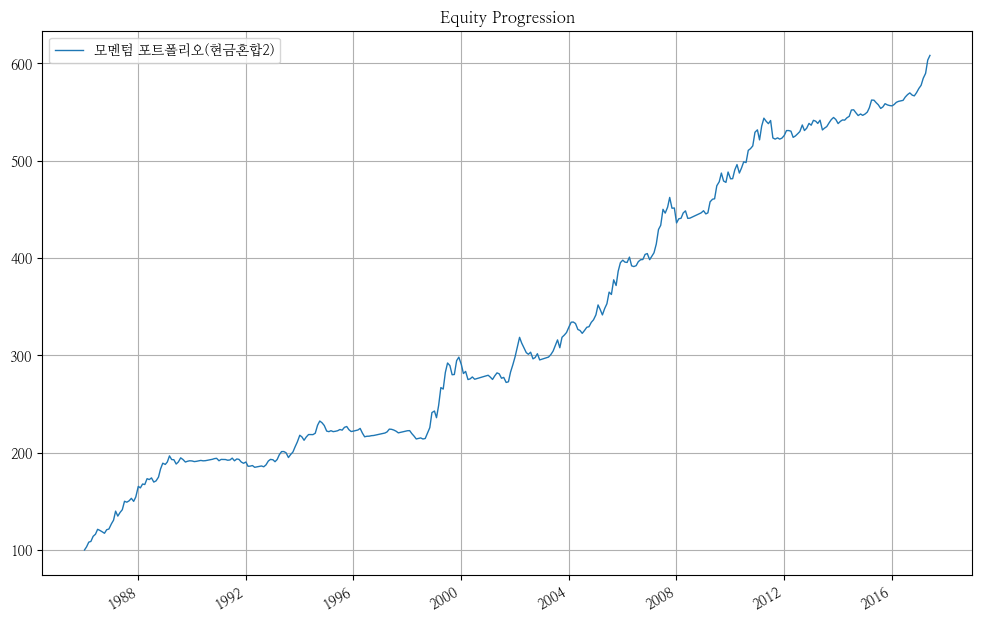

In [25]:
r_ms2.plot(figsize=(12,8));

In [26]:
r_all = bt.run(bt_ms0, bt_ms1, bt_ms2, bt_ms_0_5, bt_kospi, bt_ew)

1985-01-04 00:00:00
1985-01-04 00:00:00


In [27]:
r_all.set_date_range(start모멘텀)
r_all.stats

,모멘텀 포트폴리오(KOSPI),모멘텀 포트폴리오(현금혼합1),모멘텀 포트폴리오(현금혼합2),모멘텀 포트폴리오(현금혼합0.5),KOSPI,ew
start,1986-01-04 00:00:00,1986-01-04 00:00:00,1986-01-04 00:00:00,1986-01-04 00:00:00,1986-01-04 00:00:00,1986-01-04 00:00:00
end,2017-06-01 00:00:00,2017-06-01 00:00:00,2017-06-01 00:00:00,2017-06-01 00:00:00,2017-06-01 00:00:00,2017-06-01 00:00:00
rf,0.000,0.000,0.000,0.000,0.000,0.000
total_return,24.627,8.090,5.083,12.120,13.910,8.074
cagr,0.109,0.073,0.059,0.085,0.090,0.073
max_drawdown,-0.331,-0.191,-0.087,-0.316,-0.731,-0.609
calmar,0.329,0.381,0.679,0.270,0.123,0.119
mtd,0.019,0.011,0.008,0.013,0.019,0.017
three_month,0.143,0.075,0.053,0.098,0.143,0.124
six_month,0.177,0.094,0.067,0.122,0.180,0.156


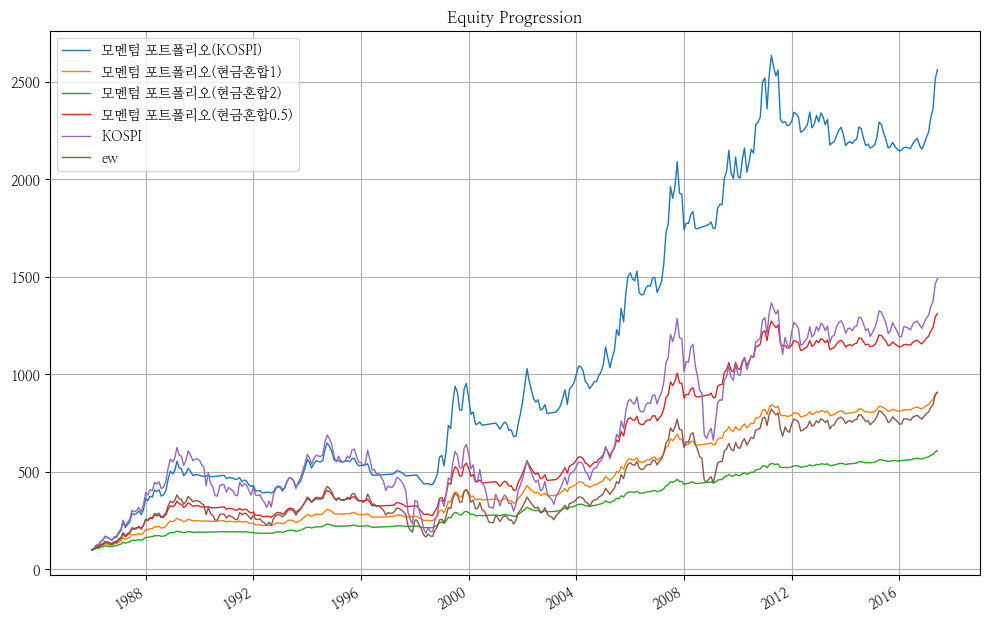

In [28]:
r_all.set_date_range(start모멘텀)
r_all.plot(figsize=(12,8));

In [29]:
r_kospi = bt.run(bt_kospi)
r_현금 = bt.run(bt_현금)

1985-01-04 00:00:00


## 그림 2.28

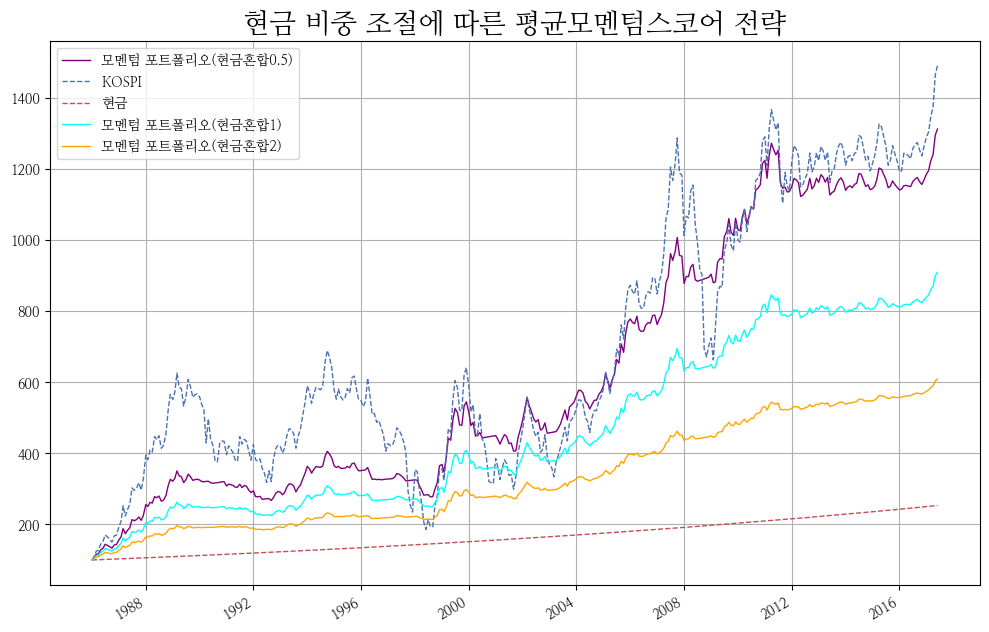

In [45]:
# 그림 2.28
r_ms_0_5.set_date_range(start모멘텀)
r_kospi.set_date_range(start모멘텀)
r_현금.set_date_range(start모멘텀)
r_ms1.set_date_range(start모멘텀)
r_ms2.set_date_range(start모멘텀)
ax1 = r_ms_0_5.plot(color='purple', figsize=(12,8));
r_kospi.plot(ax=ax1, ls='--', color='b', figsize=(12, 8));
r_현금.plot(ax=ax1, ls='--', color='r', figsize=(12, 8));
#----
r_ms1.plot(ax=ax1, ls='-', color='cyan', figsize=(12, 8));
r_ms2.plot(ax=ax1, ls='-', color='orange', figsize=(12, 8));
plt.title("현금 비중 조절에 따른 평균모멘텀스코어 전략", fontsize=20);

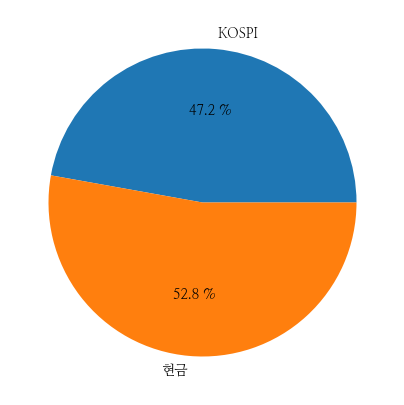

In [46]:
r_ms_0_5.get_security_weights()[s:e].sum(axis=0).plot.pie(autopct='%.1f %%', ylabel='', figsize=(5,5));

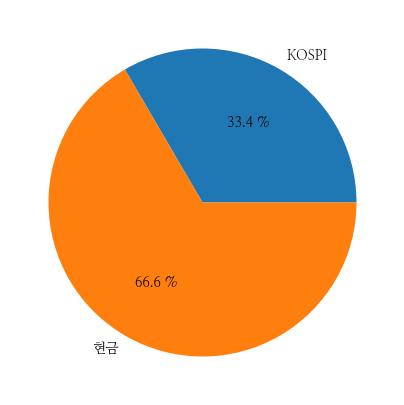

In [47]:
r_ms1.get_security_weights()[s:e].sum(axis=0).plot.pie(autopct='%.1f %%', ylabel='', figsize=(5,5));

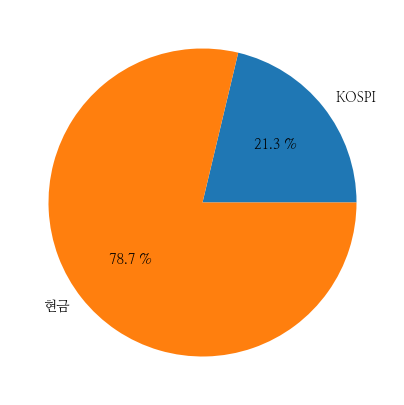

In [48]:
r_ms2.get_security_weights()[s:e].sum(axis=0).plot.pie(autopct='%.1f %%', ylabel='', figsize=(5,5));

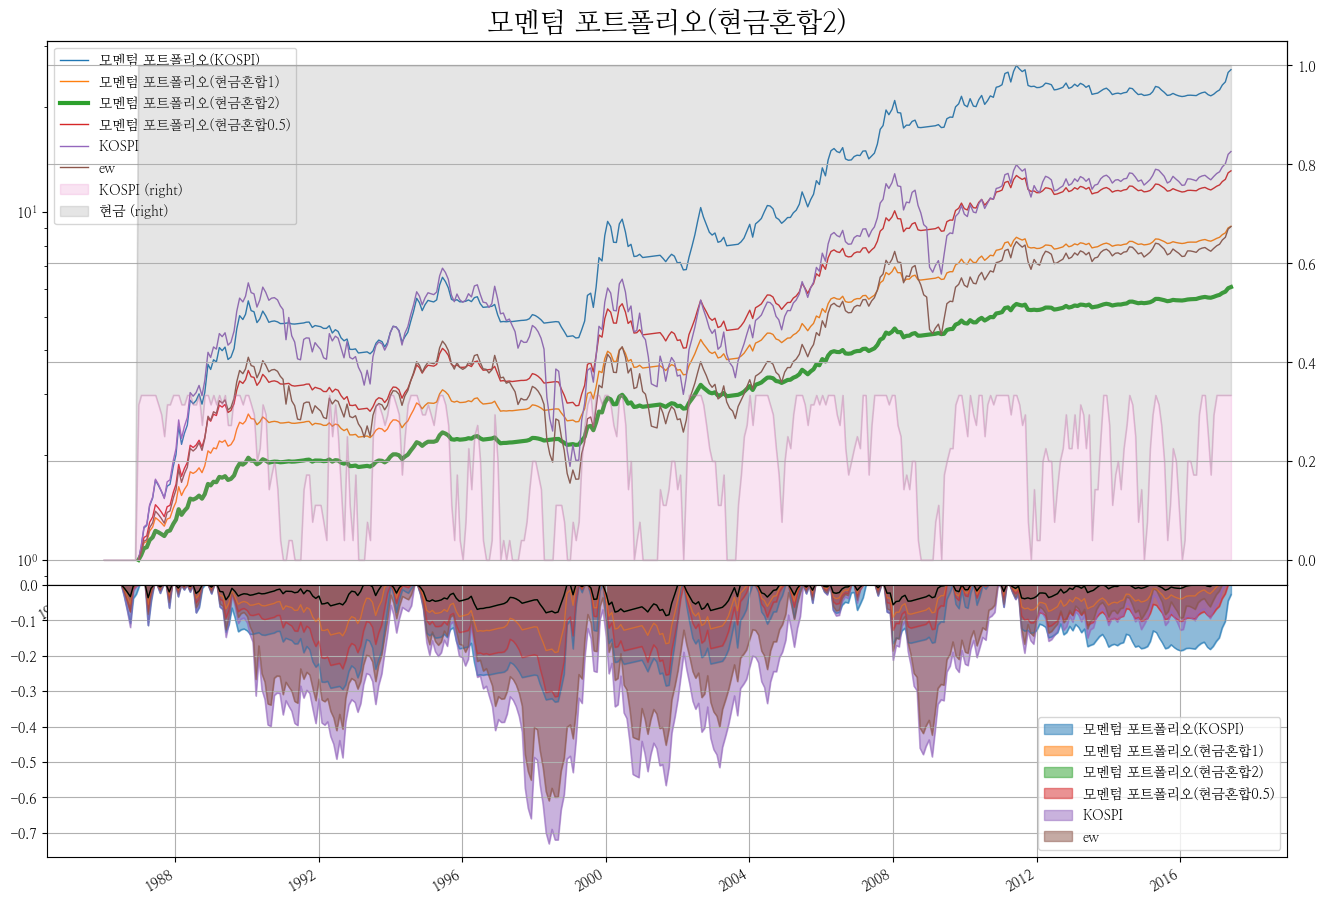

In [49]:
plot_assets(r_all, s, e, '모멘텀 포트폴리오(현금혼합2)')

In [31]:
# qs.reports.full(r_all.prices['모멘텀 포트폴리오(현금혼합2)'].to_returns().dropna()['1986':],
#                 r_all.prices['KOSPI'].to_returns().dropna()['1986':])

# 일일데이터

In [50]:
s, e, start모멘텀

('1985-1-4', '2017-12-31', '1986-1-4')

In [51]:
pd.date_range(s, '2017-12-31', freq='Y')

DatetimeIndex(['1985-12-31', '1986-12-31', '1987-12-31', '1988-12-31',
               '1989-12-31', '1990-12-31', '1991-12-31', '1992-12-31',
               '1993-12-31', '1994-12-31', '1995-12-31', '1996-12-31',
               '1997-12-31', '1998-12-31', '1999-12-31', '2000-12-31',
               '2001-12-31', '2002-12-31', '2003-12-31', '2004-12-31',
               '2005-12-31', '2006-12-31', '2007-12-31', '2008-12-31',
               '2009-12-31', '2010-12-31', '2011-12-31', '2012-12-31',
               '2013-12-31', '2014-12-31', '2015-12-31', '2016-12-31',
               '2017-12-31'],
              dtype='datetime64[ns]', freq='A-DEC')

In [52]:
s = '1985-1-4'
e = '2017-12-31'
kospi = fdr.DataReader("KS11")['Close']
data_daily = pd.DataFrame()
data_daily['KOSPI'] = kospi.copy()
data_daily = data_daily[s:e]
# %%
dd = pd.DataFrame()
dd.index = pd.date_range(s, e, freq='D')
denominator = len(pd.date_range(s, e, freq='D'))/len(pd.date_range(s, e, freq='Y'))
dd['현금'] = pow(1.03, 1/denominator)
dd['현금'] = dd['현금'].shift(1, fill_value=1.0)
dd['현금'] = dd['현금'].cumprod()
#%%
data_daily = pd.merge(data_daily, dd, left_index=True, right_index=True, how='left')

In [53]:
data_daily

,KOSPI,현금
Date,,
1985-01-04,139.530,1.000
1985-01-05,141.790,1.000
1985-01-07,145.510,1.000
1985-01-08,145.390,1.000
1985-01-09,143.260,1.000
...,...,...
2017-12-21,2429.830,2.650
2017-12-22,2440.540,2.650
2017-12-26,2427.340,2.651


In [56]:
# 월말에 계산하고 다음월 첫 거래일 종가로 거래 한다고 전재
# 12개월 평균모멘텀스코어 계산

class WeighAMSWithCash(bt.Algo):
    def __init__(self, lag1, months, cash, cash_weight):
        super(WeighAMSWithCash, self).__init__()
        self.lag1 = lag1
        self.months = months
        self.cash = cash
        self.cash_weight = cash_weight

    def 평균모멘텀스코어(self, 데이터, 개월):
        초기값 = 0
        for i in range(1, 개월+1):
            초기값 += np.where(데이터 / 데이터.shift(i) > 1, 1, 0)
        return 초기값[-1]/개월

    def AMS(self, prc):
        ''' x : Series (DataFrame의 컬럼)
            x[-1] : 기준일. x의 현재값
            (오늘날짜/과거날짜 - 1) > 0 보다 크면 1, 아니면 0
            => 오늘날짜/과거날짜 > 1 => 오늘날짜 > 과거날짜  => x[-1] > x
        '''
        average_momentum_score = pd.Series(dtype='float64')
        # print(f"{list(np.where(x[-1]>x, 1, 0)[:-1])}, {len(np.where(x[-1]>x, 1, 0)[:-1])}")
        for c in prc.columns:
            average_momentum_score[c] = np.mean(np.where(prc[c][-1]>prc[c], 1, 0)[:-1])# 당일 날짜 비교는 제외해준다 [:-1]

        return average_momentum_score

    def __call__(self, target):
        selected = target.temp['selected'].copy()

        t0 = (target.now - pd.DateOffset(months=self.lag1)).strftime("%Y-%m")
        start = (target.now - pd.DateOffset(months=self.lag1) - pd.DateOffset(months=self.months)).strftime("%Y-%m")

        prc = target.universe[selected].loc[start:t0].resample('M').last()
        if (len(prc) < self.months+1):
            return False

        # weights = pd.Series(self.평균모멘텀스코어(prc, self.months), index=selected)
        weights = pd.Series(self.AMS(prc), index=selected)
        weights[self.cash] *= self.cash_weight # 현금비중 적용
        weights = weights/weights.sum()
        
        # print(self.평균모멘텀스코어(prc, self.months), prc)
        target.temp['weights'] = weights

        return True

In [57]:
# 월말에 계산하고 다음월 첫 거래일 종가로 거래 한다고 전재
# 12개월 평균모멘텀스코어 계산

class WeighAMSWithCash1(bt.Algo):
    def __init__(self, lag, lookback, cash, cash_weight):
        super(WeighAMSWithCash1, self).__init__()
        self.lag = lag
        self.lookback = lookback
        self.cash = cash
        self.cash_weight = cash_weight

    def average_momentum_score(self, t0, prices):
        momentums_score = 0
        for m in range(1, self.lookback+1):
            start = t0 - pd.DateOffset(months=m)
            prc = prices.loc[start:t0]
            momentum_score = np.where(prc.calc_total_return() > 0, 1, 0)
            momentums_score += momentum_score

        return pd.Series(momentums_score / self.lookback, index=prices.columns)

    def __call__(self, target):
        selected = target.temp['selected'].copy()

        t0 = target.now - self.lag
        start = t0 - pd.DateOffset(months=self.lookback)
        print(f"{target.now} prc {start} ~ {t0}")
        prc = target.universe.loc[start:t0, selected]
        if len(prc) < 1 or prc.isnull().values.any():
            print(f"{target.now} not yet data")
            return False

        weights = pd.Series(self.average_momentum_score(t0, prc), index=selected)
        weights[self.cash] *= self.cash_weight # (1) 현금비중을 곱해준다.
        weights = weights/weights.sum() 
        
        target.temp['weights'] = weights

        return True

In [58]:
#%%
def momentum_mixedcash(name, data, lag=0, months=12, cash='현금', cash_weight=1):
    st = bt.Strategy(name,
        [
            bt.algos.RunMonthly(run_on_first_date=True,
                                run_on_end_of_period=False,
                                run_on_last_date=False),
            bt.algos.SelectThese(['KOSPI', '현금']),
            # WeighAMSWithCash(lag=lag, months=months, cash=cash, cash_weight=cash_weight), 
            WeighAMSWithCash1(lag=pd.DateOffset(months=0), lookback=months, cash=cash, cash_weight=cash_weight),
            PrintTempWeights(),
            bt.algos.Rebalance()
        ]
    )
    test = bt.Backtest(st, data, initial_capital=100000000)
    return test

In [60]:
data = data.resample('MS').first() #XXX 매월 1일자로 변경
bt_2 = momentum_mixedcash("모멘텀(현금혼합2)", data, cash_weight=2)
r_12 = bt.run(bt_2, bt_ms2)

1985-01-01 00:00:00 prc 1984-01-01 00:00:00 ~ 1985-01-01 00:00:00
1985-01-01 00:00:00 not yet data
1985-02-01 00:00:00 prc 1984-02-01 00:00:00 ~ 1985-02-01 00:00:00
1985-02-01 00:00:00 not yet data
1985-03-01 00:00:00 prc 1984-03-01 00:00:00 ~ 1985-03-01 00:00:00
1985-03-01 00:00:00 not yet data
1985-04-01 00:00:00 prc 1984-04-01 00:00:00 ~ 1985-04-01 00:00:00
1985-04-01 00:00:00 not yet data
1985-05-01 00:00:00 prc 1984-05-01 00:00:00 ~ 1985-05-01 00:00:00
1985-05-01 00:00:00 not yet data
1985-06-01 00:00:00 prc 1984-06-01 00:00:00 ~ 1985-06-01 00:00:00
1985-06-01 00:00:00 not yet data
1985-07-01 00:00:00 prc 1984-07-01 00:00:00 ~ 1985-07-01 00:00:00
1985-07-01 00:00:00 not yet data
1985-08-01 00:00:00 prc 1984-08-01 00:00:00 ~ 1985-08-01 00:00:00
1985-08-01 00:00:00 not yet data
1985-09-01 00:00:00 prc 1984-09-01 00:00:00 ~ 1985-09-01 00:00:00
1985-09-01 00:00:00 not yet data
1985-10-01 00:00:00 prc 1984-10-01 00:00:00 ~ 1985-10-01 00:00:00
1985-10-01 00:00:00 not yet data
1985-11-01

In [61]:
# 처음과 동일함을 검증(로직)
r_12.set_date_range(start모멘텀)
r_12.display()

Stat                 모멘텀(현금혼합2)    모멘텀 포트폴리오(현금혼합2)
-------------------  -------------------  ------------------------------
Start                1986-02-01           1986-02-01
End                  2017-06-01           2017-06-01
Risk-free rate       0.00%                0.00%

Total Return         489.42%              489.42%
Daily Sharpe         -                    -
Daily Sortino        -                    -
CAGR                 5.83%                5.83%
Max Drawdown         -7.94%               -7.94%
Calmar Ratio         0.73                 0.73

MTD                  -                    -
3m                   5.32%                5.32%
6m                   6.72%                6.72%
YTD                  6.72%                6.72%
1Y                   8.22%                8.22%
3Y (ann.)            3.37%                3.37%
5Y (ann.)            2.97%                2.97%
10Y (ann.)           3.44%                3.44%
Since Incep. (ann.)  5.83%                5.83%

Daily Sh

일일데이터(data_daily) 사용

In [62]:
bt_daily_0_5 = momentum_mixedcash("모멘텀(현금혼합0.5,일간)", data_daily, cash_weight=0.5)
bt_daily_1 = momentum_mixedcash("모멘텀(현금혼합1,일간)", data_daily, cash_weight=1)
bt_daily_2 = momentum_mixedcash("모멘텀(현금혼합2,일간)", data_daily, cash_weight=2)

In [63]:
r_daily = bt.run(bt_daily_2, bt_daily_1, bt_daily_0_5)

1985-01-04 00:00:00 prc 1984-01-04 00:00:00 ~ 1985-01-04 00:00:00
1985-01-04 00:00:00 not yet data
1985-02-01 00:00:00 prc 1984-02-01 00:00:00 ~ 1985-02-01 00:00:00
1985-02-01 00:00:00 not yet data
1985-03-02 00:00:00 prc 1984-03-02 00:00:00 ~ 1985-03-02 00:00:00
1985-03-02 00:00:00 not yet data
1985-04-01 00:00:00 prc 1984-04-01 00:00:00 ~ 1985-04-01 00:00:00
1985-04-01 00:00:00 not yet data
1985-05-01 00:00:00 prc 1984-05-01 00:00:00 ~ 1985-05-01 00:00:00
1985-05-01 00:00:00 not yet data
1985-06-01 00:00:00 prc 1984-06-01 00:00:00 ~ 1985-06-01 00:00:00
1985-06-01 00:00:00 not yet data
1985-07-01 00:00:00 prc 1984-07-01 00:00:00 ~ 1985-07-01 00:00:00
1985-07-01 00:00:00 not yet data
1985-08-01 00:00:00 prc 1984-08-01 00:00:00 ~ 1985-08-01 00:00:00
1985-08-01 00:00:00 not yet data
1985-09-02 00:00:00 prc 1984-09-02 00:00:00 ~ 1985-09-02 00:00:00
1985-09-02 00:00:00 not yet data
1985-10-02 00:00:00 prc 1984-10-02 00:00:00 ~ 1985-10-02 00:00:00
1985-10-02 00:00:00 not yet data
1985-11-01

In [64]:
r_daily.set_date_range(start모멘텀)
r_daily.stats

,"모멘텀(현금혼합2,일간)","모멘텀(현금혼합1,일간)","모멘텀(현금혼합0.5,일간)"
start,1986-01-04 00:00:00,1986-01-04 00:00:00,1986-01-04 00:00:00
end,2017-12-28 00:00:00,2017-12-28 00:00:00,2017-12-28 00:00:00
rf,0.000,0.000,0.000
total_return,5.250,8.349,12.417
cagr,0.059,0.072,0.085
max_drawdown,-0.103,-0.168,-0.275
calmar,0.570,0.432,0.308
mtd,0.000,-0.001,-0.002
three_month,0.018,0.023,0.028
six_month,0.021,0.025,0.028


In [65]:
r_daily.prices[s:e].resample('MS').first().to_drawdown_series().describe()

,"모멘텀(현금혼합2,일간)","모멘텀(현금혼합1,일간)","모멘텀(현금혼합0.5,일간)"
count,384.000,384.000,384.000
mean,-0.022,-0.052,-0.087
std,0.021,0.042,0.067
min,-0.080,-0.152,-0.250
25%,-0.040,-0.081,-0.129
50%,-0.018,-0.054,-0.094
75%,0.000,-0.010,-0.018
max,0.000,0.000,0.000


In [67]:
bt_kospi1 = long_only_ew(data_daily, ['KOSPI'], 'KOSPI')
bt_현금1 = long_only_ew(data_daily, ['현금'], '현금')
r_kospi1 = bt.run(bt_kospi1)
r_현금1 = bt.run(bt_현금1)

r_daily_0_5 = bt.run(bt_daily_0_5)
r_daily_1 = bt.run(bt_daily_1)
r_daily_2 = bt.run(bt_daily_2)

1985-01-04 00:00:00
1985-01-04 00:00:00


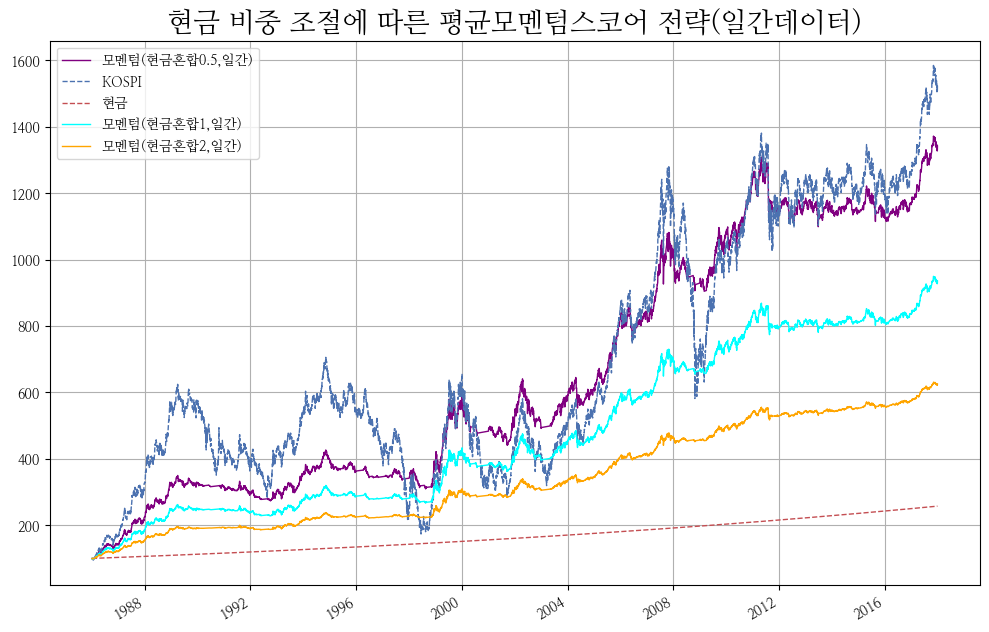

In [68]:
# 그림 2.28
r_daily_0_5.set_date_range(start모멘텀)
r_kospi1.set_date_range(start모멘텀)
r_현금1.set_date_range(start모멘텀)
r_daily_1.set_date_range(start모멘텀)
r_daily_2.set_date_range(start모멘텀)
ax1 = r_daily_0_5.plot(color='purple', figsize=(12,8));
r_kospi1.plot(ax=ax1, ls='--', color='b', figsize=(12, 8));
r_현금1.plot(ax=ax1, ls='--', color='r', figsize=(12, 8));
#----
r_daily_1.plot(ax=ax1, ls='-', color='cyan', figsize=(12, 8));
r_daily_2.plot(ax=ax1, ls='-', color='orange', figsize=(12, 8));
plt.title("현금 비중 조절에 따른 평균모멘텀스코어 전략(일간데이터)", fontsize=20);

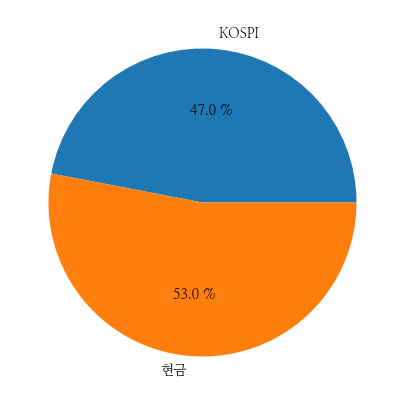

In [70]:
r_daily_0_5.get_security_weights()[s:e].sum(axis=0).plot.pie(autopct='%.1f %%', ylabel='', figsize=(5,5));

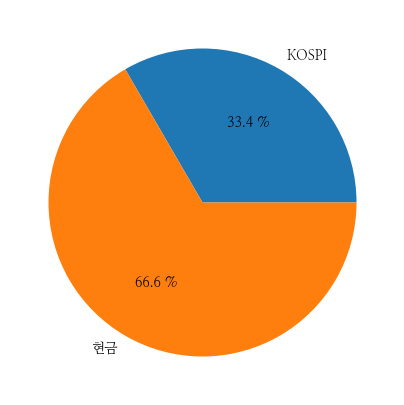

In [71]:
r_daily_1.get_security_weights()[s:e].sum(axis=0).plot.pie(autopct='%.1f %%', ylabel='', figsize=(5,5));

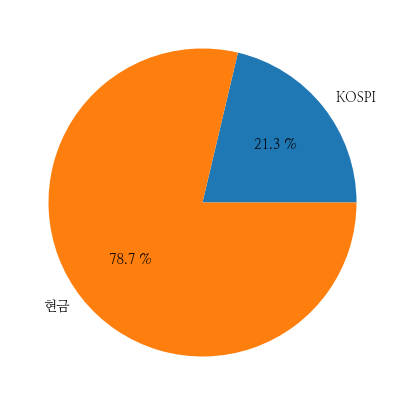

In [72]:
r_daily_2.get_security_weights()[s:e].sum(axis=0).plot.pie(autopct='%.1f %%', ylabel='', figsize=(5,5));

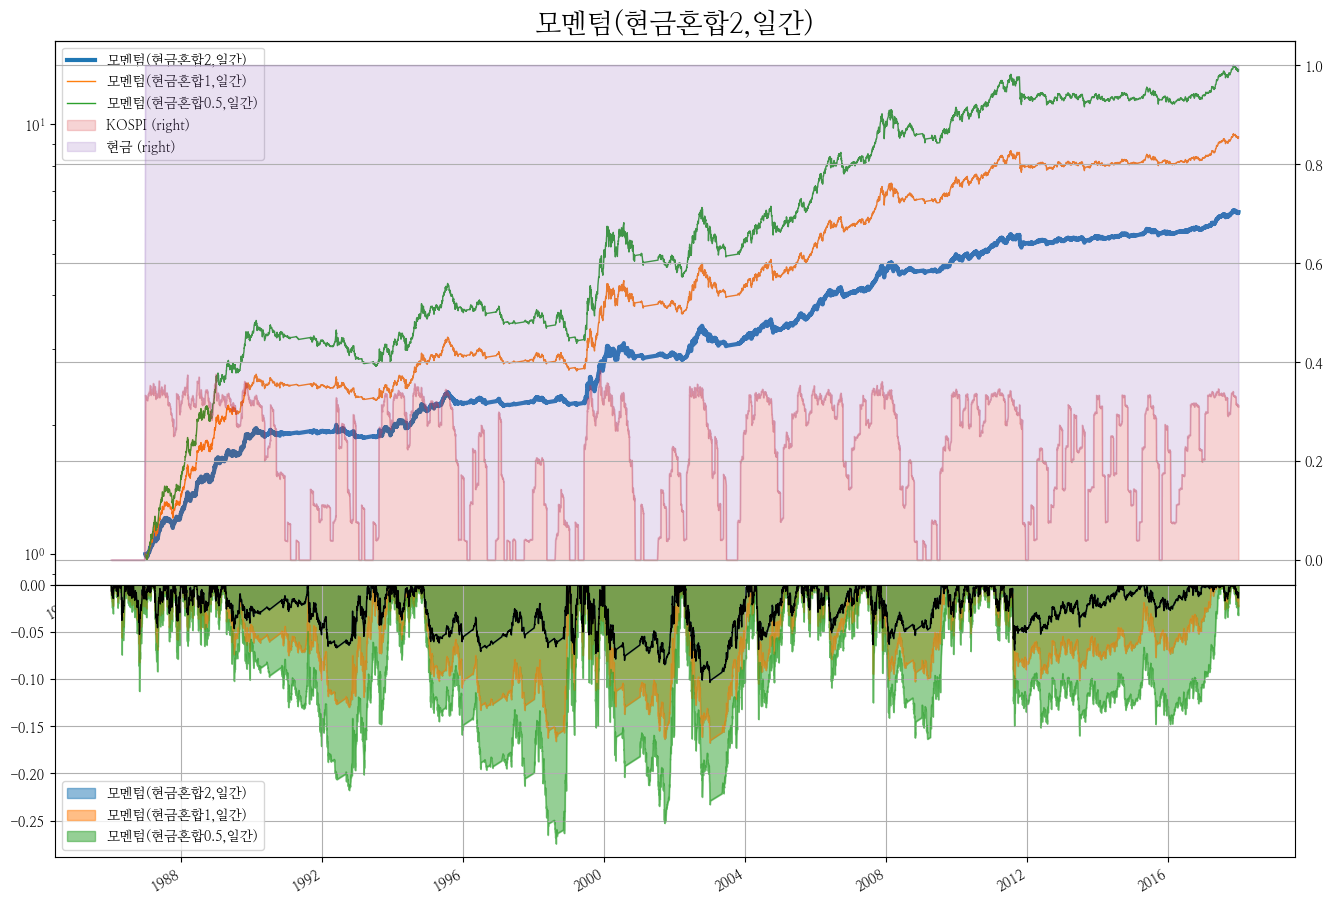

In [73]:
plot_assets(r_daily, s, e, "모멘텀(현금혼합2,일간)")